# Analisis preeliminar de los datos

## Importación de los datos desde Kaggle

In [ ]:
%%capture
! pip install kaggle wavio pydub keras-metrics

In [ ]:
import soundfile
import numpy as np
import librosa
import glob
import os
from pydub import AudioSegment
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import random
import os

### Configuración de la fuente de datos

In [ ]:
# kaggle
# processed
# processed_augmented
data_source = 'processed'
os.environ["DATA_SOURCE"] = data_source

In [ ]:
%%bash
rm -rf *

if [ "$DATA_SOURCE" == "kaggle" ];
then
mkdir ~/.kaggle
curl https://raw.githubusercontent.com/Solrak97/clasificador_de_sentimientos/main/kaggle.json > kaggle.json
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json
kaggle datasets download uwrfkaggler/ravdess-emotional-speech-audio
unzip ravdess-emotional-speech-audio.zip
fi

if [ "$DATA_SOURCE" == "processed" ];
then
curl https://raw.githubusercontent.com/Solrak97/clasificador_de_sentimientos/main/data.pkl > data.pkl
fi

if [ "$DATA_SOURCE" == "processed_augmented" ];
then
curl https://raw.githubusercontent.com/Solrak97/clasificador_de_sentimientos/main/data_augmentation.pkl > data.pkl
fi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1448k  100 1448k    0     0  10.3M      0 --:--:-- --:--:-- --:--:-- 10.3M


### Parece que existen algunos problemas de overfitting por lo que decidimos crear un poco más de muestras con data augmentation a ver si sale

In [ ]:
from pydub import AudioSegment


def cambio_velocidad(sound, speed=1.0):

    sound_with_altered_frame_rate = sound._spawn(sound.raw_data, overrides={
         "frame_rate": int(sound.frame_rate * speed)
      })

    return sound_with_altered_frame_rate.set_frame_rate(sound.frame_rate)

In [ ]:
if data_source == 'kaggle':

  for file in glob.glob("Actor_*/*.wav"):

    file_name = os.path.basename(file)
  
    # El audio viene en estereo para algunas partes así que se pasa a mono
    sound = AudioSegment.from_wav(file)
    sound = sound.set_channels(1)
    sound.export(file, format="wav")

    slow_sound = cambio_velocidad(sound, 0.81)

    fast_sound = cambio_velocidad(sound, 1.23)

    file = file.split(".")[0]
    sound.export(f'{file}-FST.wav', format="wav")
    sound.export(f'{file}-SLW.wav', format="wav")


### Transformación de los datos a las caracteristicas base del estudio Dias Issa et al.
Se extraerá un grupo de caracteristicas para analizar, hemos notado que hay diferencias en los tamaños de los audios por lo que hemos decidido revisar como funcionan correctamente los tamaños de datos y otras de estas caracteristicas.

In [ ]:
INT_2_EMOTION = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

In [ ]:
name, _len, emotions, mfccs, chromas, mels, contrasts, tonnetz = [], [], [], [], [], [], [], []

if data_source == 'kaggle':
  for file in glob.glob("Actor_*/*.wav"):
      file_name = os.path.basename(file)

      sound = AudioSegment.from_wav(file)
      sound = sound.set_channels(1)
      sound.export(file, format="wav")

      name_split = file_name.split("-")
      emotion = INT_2_EMOTION[name_split[2]]

      with soundfile.SoundFile(file) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        stft = np.abs(librosa.stft(X))
        mfccs.append(np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=84).T, axis=0))
        chromas.append(np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0))
        mels.append(np.mean(librosa.feature.melspectrogram(X, sr=sample_rate, n_mels=84).T,axis=0))
        contrasts.append(np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0))
        tonnetz.append(np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0))
        
        _len.append(librosa.get_duration(y=X, sr=sample_rate))         

      name.append(file_name)
      emotions.append(emotion)

  data = pd.DataFrame({'File name': name, 'Emotion': emotions, 'Duration': _len,
                        'MFCC': mfccs, 'Chroma': chromas, 'Mel': mels, 'Contrast': contrasts, 'Tonnetz': tonnetz})

In [ ]:
if data_source == 'kaggle':
  data.to_pickle('data.pkl')
else:
  data = pd.read_pickle('data.pkl')

## Transformación de los datos utilizando PCA

In [ ]:
X = data.drop(columns=['Emotion', 'File name'])

# Forgive me god, but it has to be done
X = np.array([np.hstack([X['MFCC'][i], X['Chroma'][i], X['Mel'][i], 
                         X['Contrast'][i], X['Tonnetz'][i]]) for i in range(len(X.index))])

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X) 


pca = PCA(3)
reduced = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.22510771, 0.09686766, 0.08505836])

### Separación no supervisada como intento de visualizar los datos agrupados.

In [ ]:
from sklearn.cluster import KMeans

label = KMeans(n_clusters=8, random_state=0).fit_predict(reduced)
labeled_kmeans = pd.DataFrame({'X': reduced[:,0], 'Y': reduced[:,1], 'label': label, 'Emotion': data['Emotion']})


filtered_label0 = reduced[label == 0]
filtered_label0 = reduced[label == 1]
filtered_label0 = reduced[label == 2]
filtered_label0 = reduced[label == 3]
filtered_label0 = reduced[label == 4]
filtered_label0 = reduced[label == 5]
filtered_label0 = reduced[label == 6]
filtered_label0 = reduced[label == 7]
 

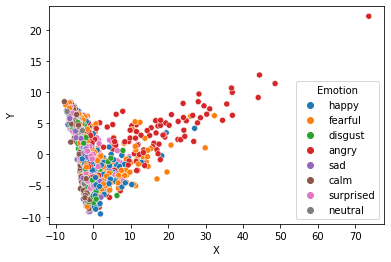

In [ ]:
sns.scatterplot(data=labeled_kmeans, x="X", y="Y", hue='Emotion')
plt.show()

## Prueba de separación con el base model

In [ ]:
from keras import Sequential
from keras.layers import Dropout, MaxPool1D, Flatten, Dense, ReLU, Input, BatchNormalization, Softmax
from keras.layers.convolutional import Conv1D
from keras.layers.advanced_activations import Softmax
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold

In [ ]:
def build_baseline():
  model = Sequential()

  # input layer
  model.add(Input(shape=(193, 1)))
  
  # Primer Convolutional layer
  model.add(Conv1D(strides=1, filters=255, kernel_size=5))
  model.add(BatchNormalization())
  model.add(ReLU())

  # Segund Convolutional layer
  model.add(Conv1D(strides=1, filters=128, kernel_size=5))
  model.add(ReLU())
  model.add(Dropout(rate=0.1))
  model.add(BatchNormalization())

  # Capa de Maxpooling
  model.add(MaxPool1D(pool_size=8))

  # 3 capas convolucionales intermedias
  model.add(Conv1D(strides=1, filters=128, kernel_size=5))
  model.add(ReLU())

  model.add(Conv1D(strides=1, filters=128, kernel_size=5))
  model.add(ReLU())

  model.add(Conv1D(strides=1, filters=128, kernel_size=5))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(Dropout(rate=0.2))

  # Capa convolucional final
  model.add(Conv1D(strides=1, filters=128, kernel_size=5))
  model.add(Flatten())
  model.add(Dropout(rate=0.2))

  # Capa densa, tiene la misma cantidad de neuronas que de clases a predecir
  model.add(Dense(units=8))
  model.add(BatchNormalization())
  model.add(Softmax())  
  return model

### Preparación de los datos

In [ ]:
# Forgive me god, but it has to be done twice
X = np.array([np.hstack([data['MFCC'][i], data['Chroma'][i], data['Mel'][i], 
                         data['Contrast'][i], data['Tonnetz'][i]]) for i in range(len(data.index))])

print(X.shape)

scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)
Y = np.array(data['Emotion'])

# Codificación de one hot encoding
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

(1440, 193)


### Entrenamiento y predicciones

In [ ]:
model = build_baseline()
model.compile(optimizer = RMSprop(learning_rate=1e-5) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
#model.summary()

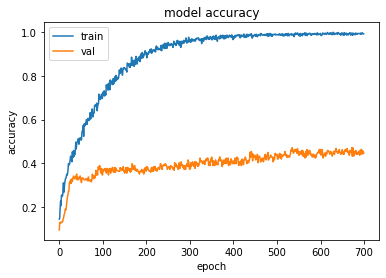

In [ ]:
history = model.fit(X_train, y_train, validation_split = 0.20, epochs=700, verbose=False)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'pred'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test)
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

9/9 [==============================] - 1s 47ms/step - loss: 1.6079 - accuracy: 0.4479
Test loss: 1.6079391241073608
Test accuracy: 0.4479166567325592


### 5-K fold validation, 700 epochs

In [ ]:
def kfold(size, k):
  index = [i for i in range(size)]
  index_reduct = index
  splits = []
  for i in range(k):
    test = random.sample(index_reduct, round(size/k))
    train = [x for x in index if x not in test]
    index_reduct = [x for x in index_reduct if x not in test]
    splits.append((train, test))
  return splits
    

In [ ]:
X = np.array([np.hstack([data['MFCC'][i], data['Chroma'][i], data['Mel'][i], 
                         data['Contrast'][i], data['Tonnetz'][i]]) for i in range(len(data.index))])


scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)
Y = np.array(data['Emotion'])

encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

fold_idx = kfold(len(y), 5)


s = 0

for train, test in fold_idx:
  X_train, X_test = X[train], X[test]
  y_train, y_test = y[train], y[test]

  model = build_baseline()
  model.compile(optimizer = RMSprop(learning_rate=1e-5) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
  model.fit(X_train, y_train, epochs=700, verbose=False)

  print(f'Model evaluation #{s}:')
  score = model.evaluate(X_test, y_test)
  print('Test loss:', score[0]) 
  print('Test accuracy:', score[1])
    
  s += 1

Model evaluation #0:
9/9 [==============================] - 1s 44ms/step - loss: 1.5775 - accuracy: 0.4618
Test loss: 1.5774568319320679
Test accuracy: 0.4618055522441864
